Cash Flow Analsyis, on and Hardy for complete analysis. Including Withdrawals

Processing NSE_NIFTY240620C23400, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23500, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23550, 15.csv in NIFTY...
Processing NSE_NIFTY240620C23600, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23400, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23500, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23550, 15.csv in NIFTY...
Processing NSE_NIFTY240620P23600, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23300, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23400, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23450, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23500, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23550, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23600, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23700, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23750, 15.csv in NIFTY...
Processing NSE_NIFTY240627C23800, 15.csv in NIFTY...
Processing NSE_NIFTY240627P23400, 15.csv in NIFTY...
Processing NSE_NIFTY240627P23500, 15.csv in NI

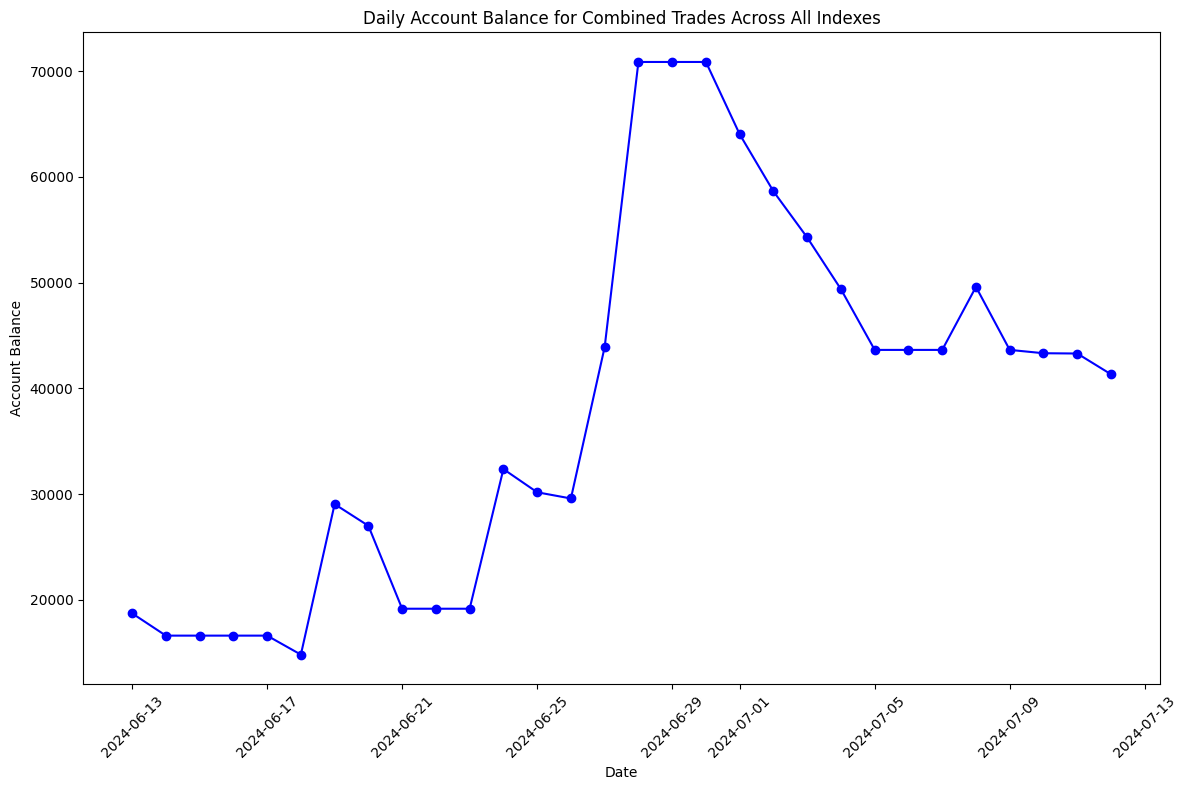

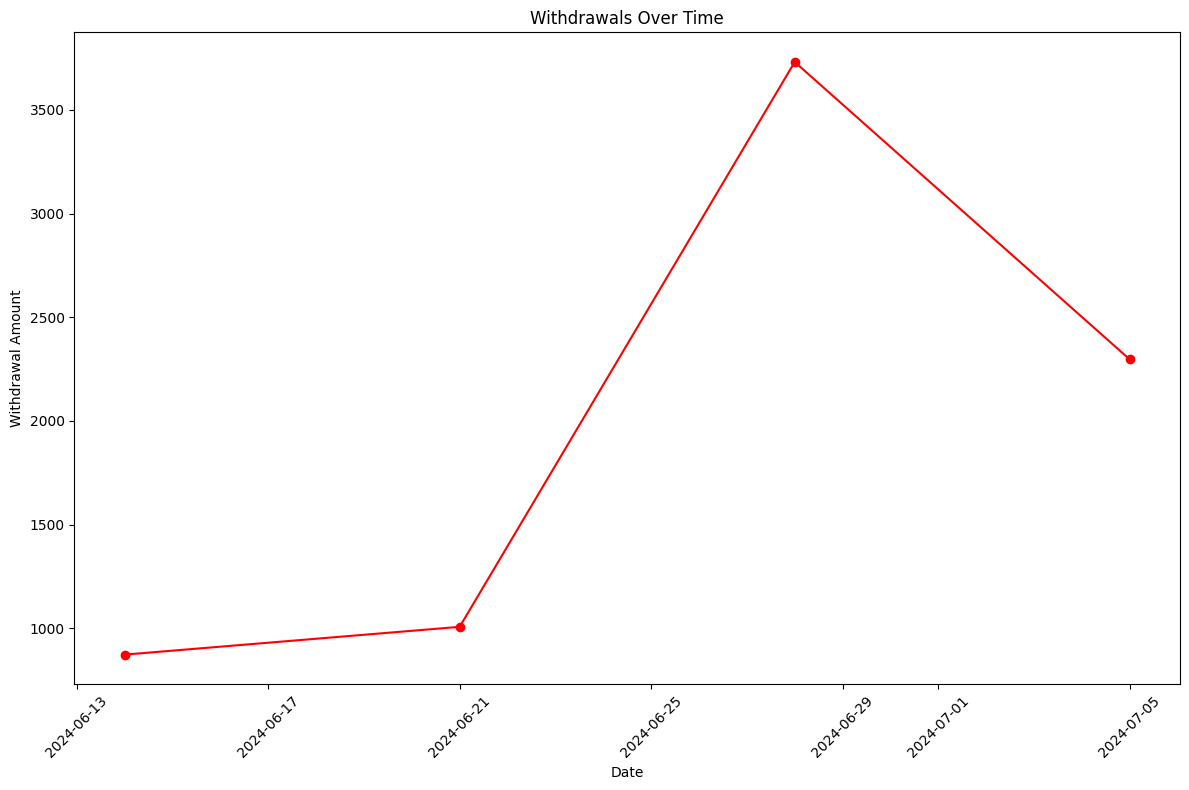

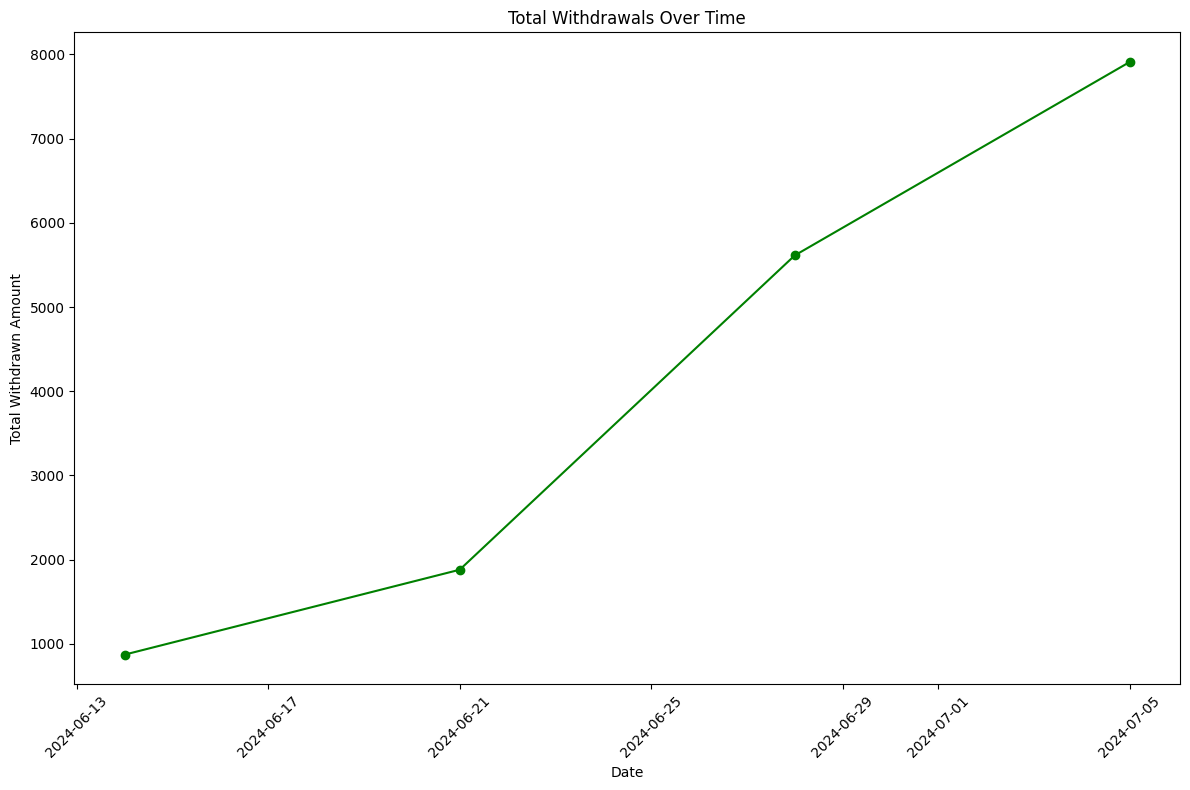

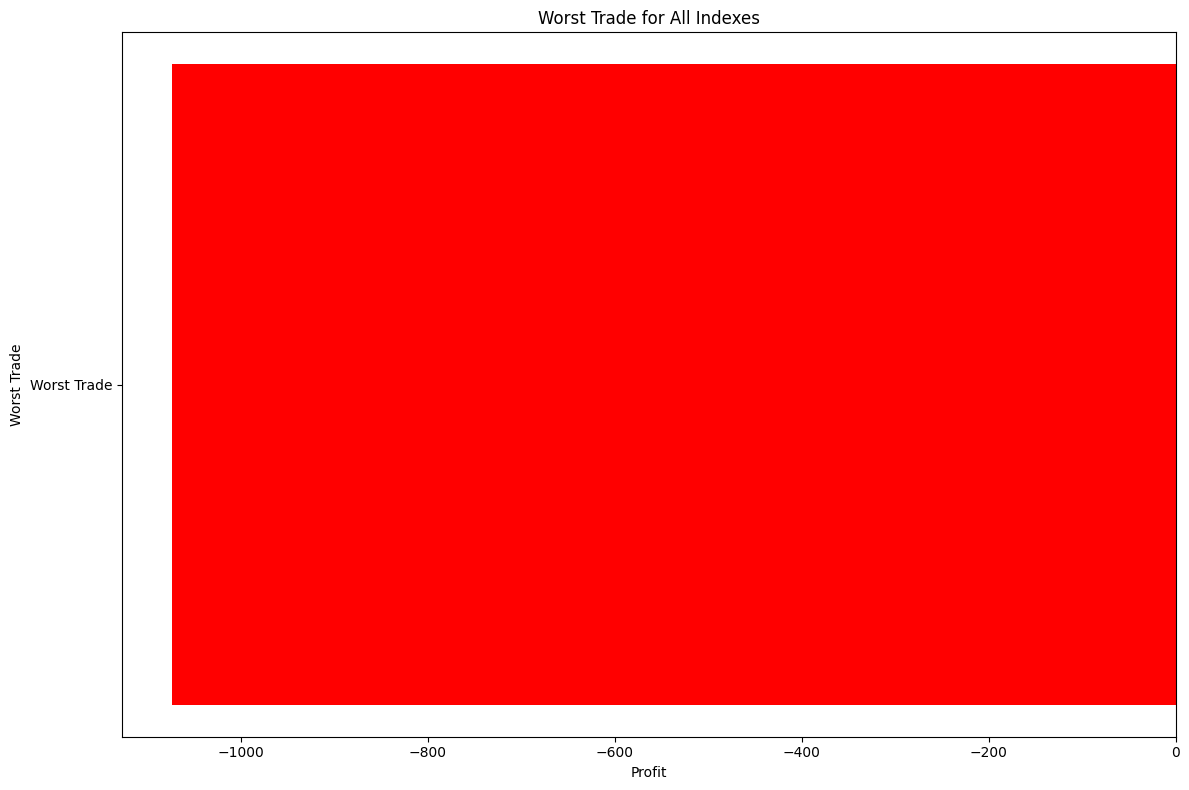

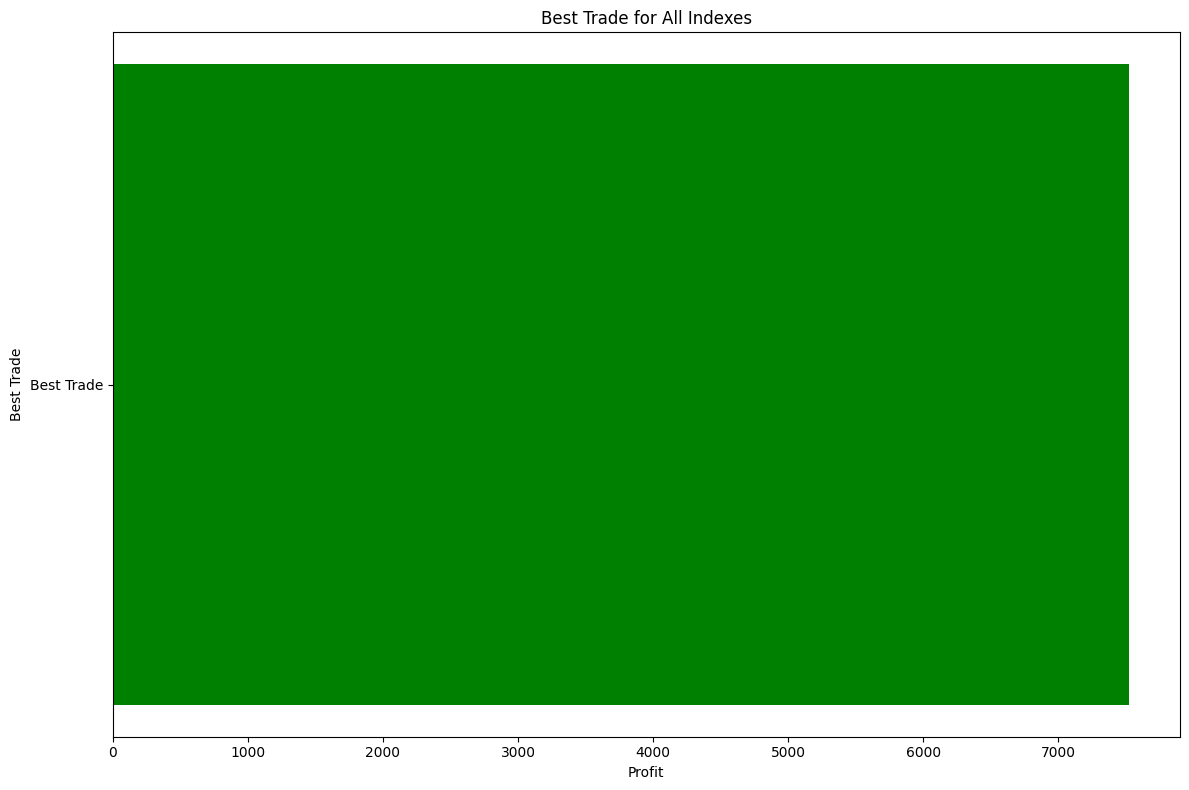

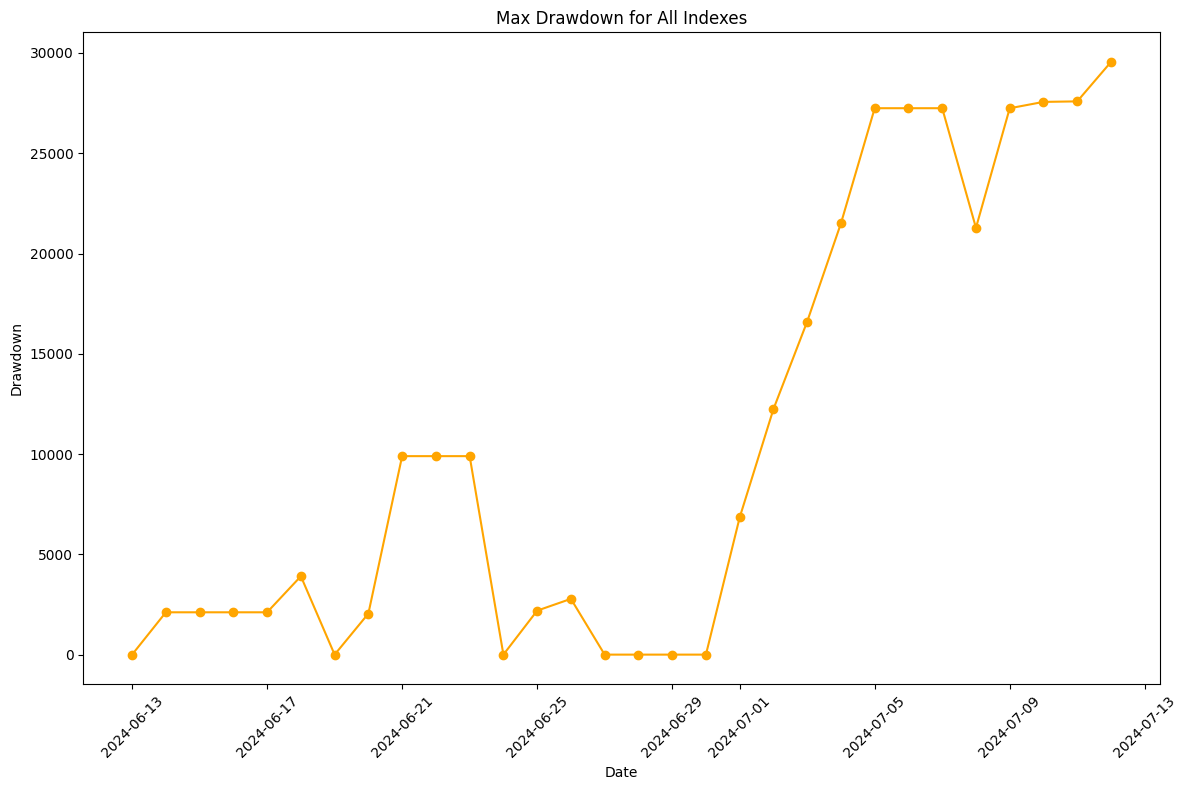

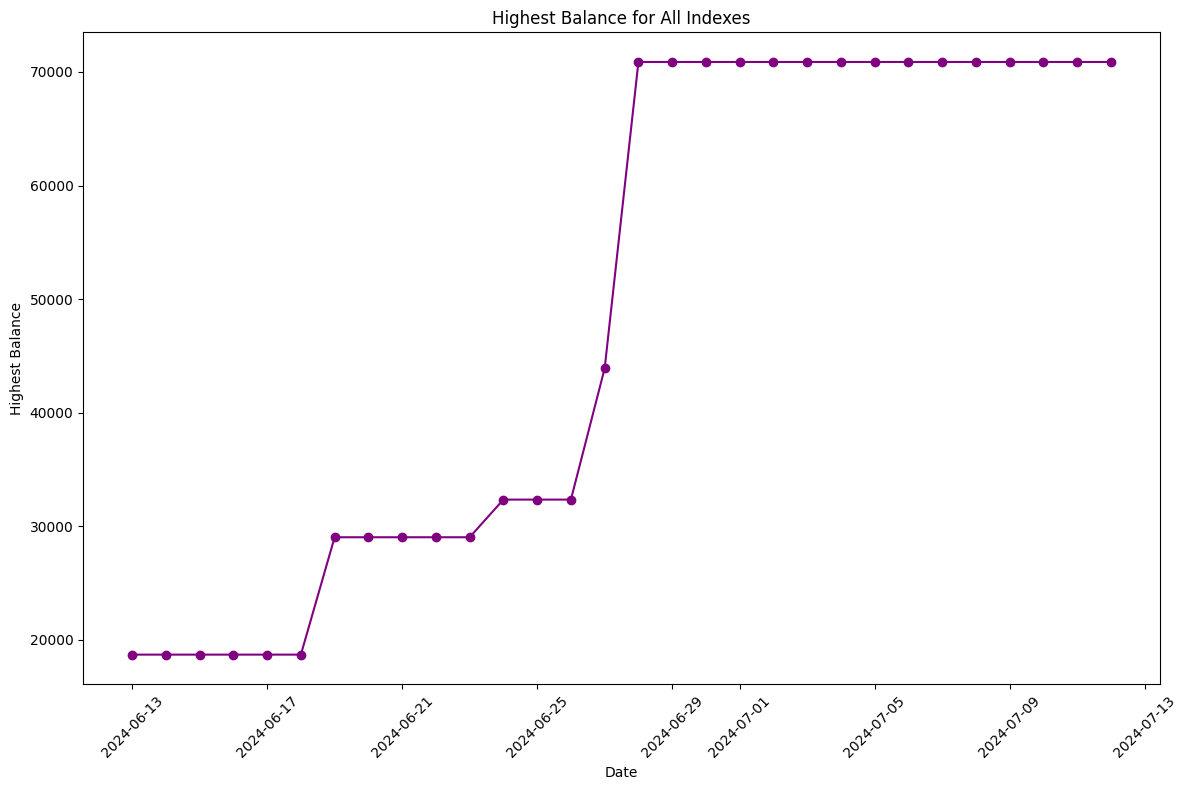

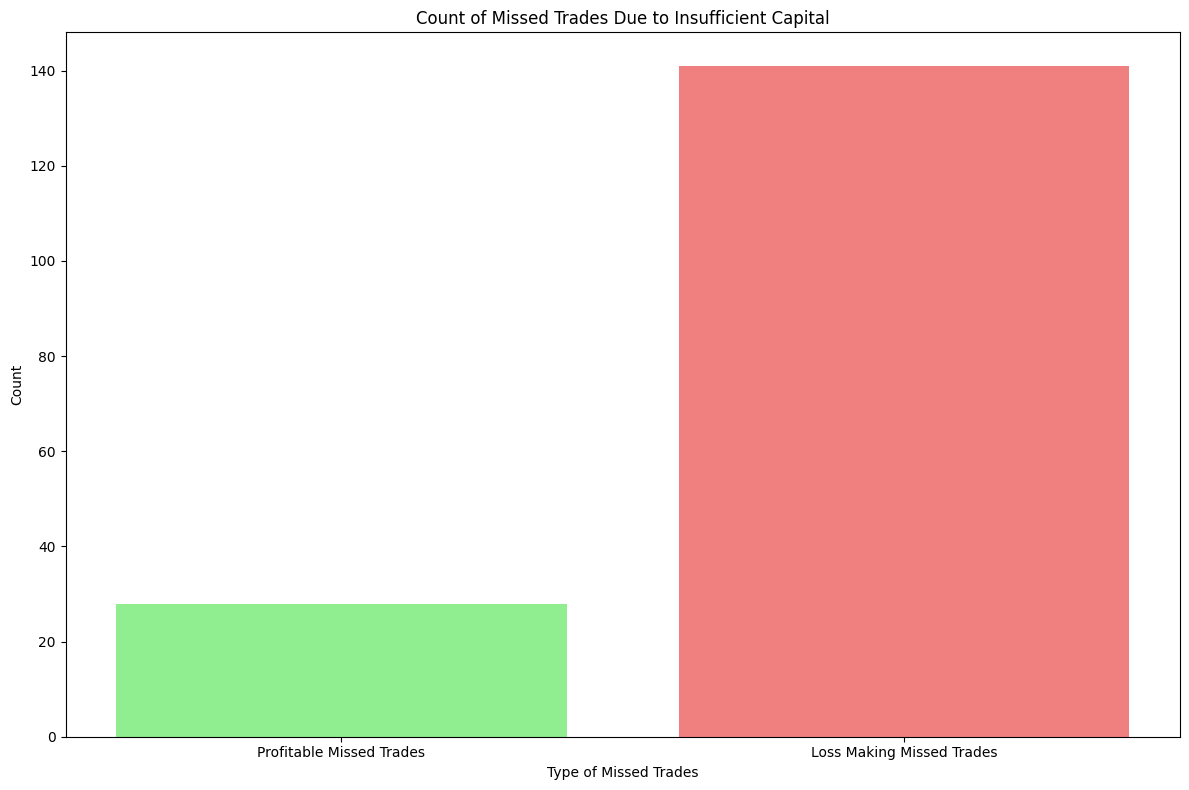

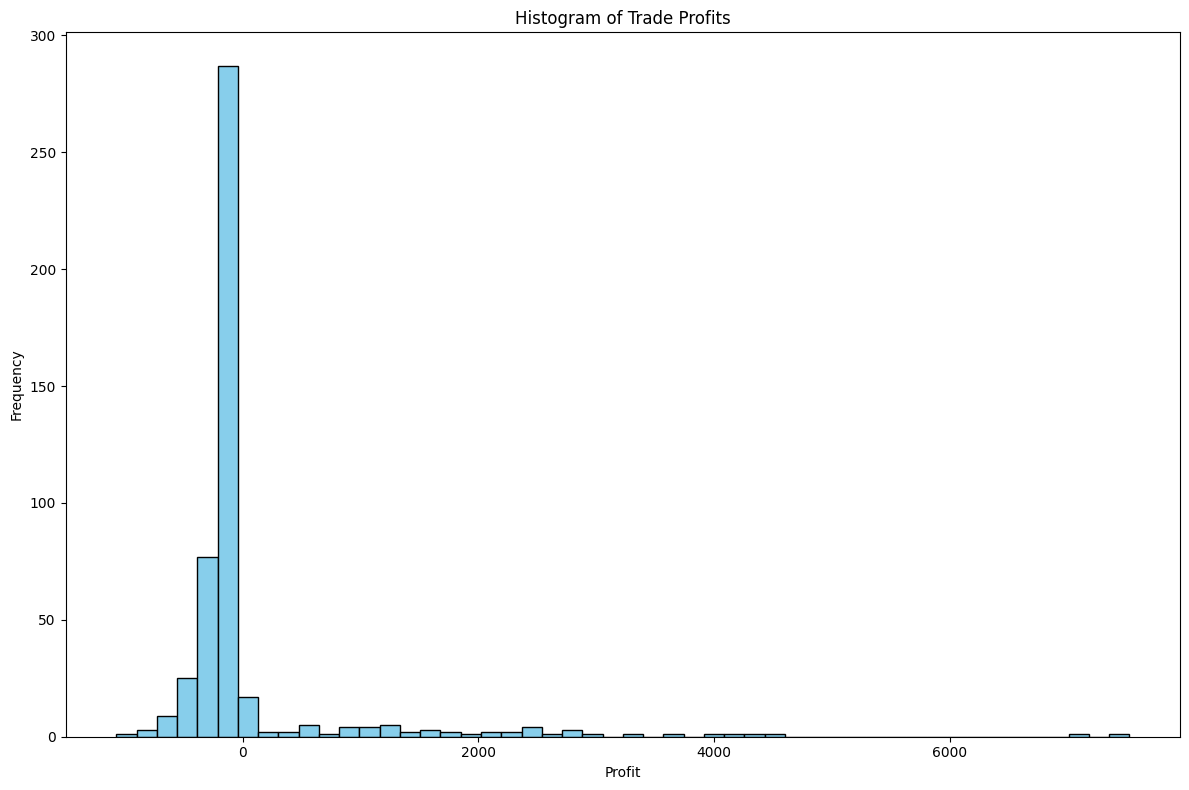

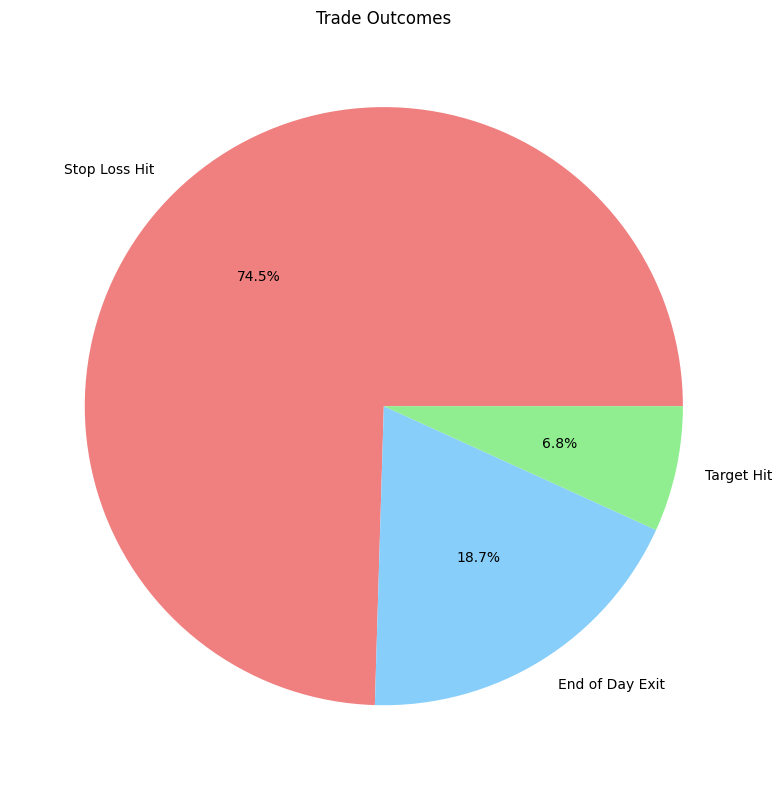

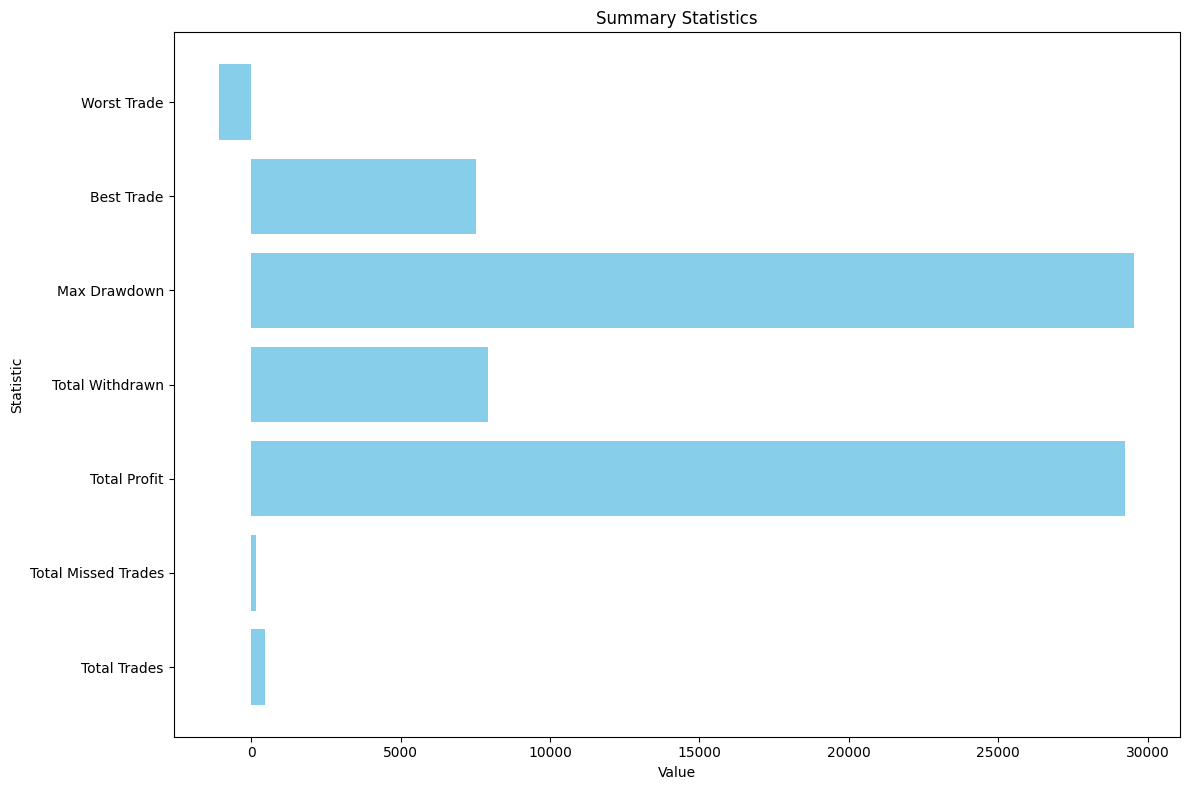

Final summary statistics:
   Total Trades  Total Missed Trades  Total Profit  Total Withdrawn  \
0           471                  169  29239.341989      7908.780756   

   Max Drawdown   Best Trade  Worst Trade  
0  29552.185101  7523.790257 -1073.565999  
Final Balance: 41330.56123248787
Max Drawdown: 29552.185100837298
Best Trade: 7523.790256515003
Worst Trade: -1073.5659991200016
Total Trades: 471
Total Missed Trades: 169
Total Profit: 29239.34198856371
Total Withdrawn: 7908.780756075799
Total Profitable Trades: 62
Total Loss Making Trades: 409
Analysis and visualization complete.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime

# Function to read best PNL combinations from a file
def read_best_pnl(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        best_pnl_values = {
            'NIFTY': {'stop_loss': float(lines[0].strip()), 'target': float(lines[1].strip())},
            'BANKNIFTY': {'stop_loss': float(lines[2].strip()), 'target': float(lines[3].strip())},
            'FINNIFTY': {'stop_loss': float(lines[4].strip()), 'target': float(lines[5].strip())}
        }
    return best_pnl_values

# Function to filter buy signals from the 15-minute chart data
def filter_signals(data):
    buy_signals = data[(data['Original Buy Signal'] == True) & (data['Short Signal'] == False)]
    return buy_signals

# Function to calculate charges
def calculate_charges(entry_price, exit_price, quantity):
    brokerage = 40  # total brokerage for one complete buy and sell
    stt_ctt = 0.00125 * exit_price * quantity
    transaction_charges = 0.000495 * (entry_price + exit_price) * quantity
    gst = 0.18 * (brokerage + transaction_charges)
    sebi_charges = 10 / 10**7 * (entry_price + exit_price) * quantity
    stamp_charges = 0.00003 * entry_price * quantity
    total_charges = brokerage + stt_ctt + transaction_charges + gst + sebi_charges + stamp_charges
    return total_charges

# Function to simulate day trades with error margin
def simulate_day_trades(buy_signals, minute_data, symbol, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005, error_margin=0.01):
    results = []

    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close']  # Adjust entry price with error margin
        entry_time = buy_signal['time'] + 900  # Add 15 minutes to the buy signal time to get the entry time
        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'symbol': symbol,
            'signal_time': buy_signal['time'],
            'entry_time': entry_time,
            'entry_price': entry_price,
            'Target Profit': profit_target,
            'Stop Loss': stop_loss,
            'Profit Price': profit_price,
            'Stop Price': stop_price,
            'exit_time': None,
            'exit_price': None,
            'charges': None,
            'profit_before_charges': None,
            'profit': None,
            'exit_reason': None,
            'missed': False
        }
        
        # Filter subsequent data for the same day only
        trade_date = pd.to_datetime(entry_time, unit='s').date()
        subsequent_data = minute_data[(minute_data['time'] > entry_time) & 
                                      (pd.to_datetime(minute_data['time'], unit='s').dt.date == trade_date)]
      
        error_margin = 0  # Default error margin for 1-minute data

        if subsequent_data.empty:
            # Use 15-minute chart data if 1-minute data is empty
            subsequent_data = minute_data_15[(minute_data_15['time'] > entry_time) & 
                                             (pd.to_datetime(minute_data_15['time'], unit='s').dt.date == trade_date)]
            error_margin = 960  # Adjust error margin for 15-minute data
            
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time'] + error_margin
                trade_result['exit_price'] = profit_price
                trade_result['exit_reason'] = 'Target Hit'
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time'] + error_margin
                trade_result['exit_price'] = stop_price
                trade_result['exit_reason'] = 'Stop Loss Hit'
                break
        else:
            # If no target or stop loss hit, exit at the last price of the day (3:25 PM)
            end_of_day_time = pd.to_datetime(trade_date) + pd.Timedelta(hours=15, minutes=25)
            eod_exit_data = minute_data[(pd.to_datetime(minute_data['time'], unit='s') <= end_of_day_time)]
            
            if eod_exit_data.empty:
                eod_exit_data = minute_data_15[(pd.to_datetime(minute_data_15['time'], unit='s') <= end_of_day_time)]
            
            if not eod_exit_data.empty:
                last_row = eod_exit_data.iloc[-1]
                trade_result['exit_time'] = last_row['time'] + error_margin
                trade_result['exit_price'] = last_row['close']
                trade_result['exit_reason'] = 'End of Day Exit'
        
        if trade_result['exit_price'] is not None:
            quantity = 25 if 'NIFTY' in symbol else 15 if 'BANKNIFTY' in symbol else 40 if 'FINNIFTY' in symbol else 10
            gross_profit = (trade_result['exit_price'] - trade_result['entry_price']) * quantity
            charges = calculate_charges(trade_result['entry_price'], trade_result['exit_price'], quantity)
            net_profit = gross_profit - charges
            trade_result['charges'] = charges
            trade_result['profit_before_charges'] = gross_profit
            trade_result['profit'] = net_profit

        results.append(trade_result)
    
    results_df = pd.DataFrame(results)

    return results_df.dropna(subset=['entry_price'])

# Function to simulate live trading account with weekend withdrawal
def simulate_live_trading(all_trades, initial_balance, withdrawal_percentage=0.05):
    account_balance = initial_balance
    active_trades = []
    daily_balance = []
    missed_trades = []
    executed_trades = []
    withdrawals = []

    current_time = pd.to_datetime(all_trades['entry_time'].min(), unit='s')
    end_time = pd.to_datetime(all_trades['exit_time'].max(), unit='s')
    print(f"Simulating live trading from {current_time} to {end_time}...")
    trading_end_time = current_time.replace(hour=11, minute=30, second=0, microsecond=0)
    withdrawal_time= current_time.replace(hour=11, minute=25, second=0, microsecond=0)

    while current_time <= end_time:

        # Skip non-trading hours
        if current_time.time() > trading_end_time.time():
            current_time = current_time + timedelta(days=1)
            current_time = current_time.replace(hour=3, minute=30, second=0, microsecond=0)
            continue

        # Perform weekend withdrawal at market close on Fridays
        if current_time.weekday() == 4 and current_time.time() == withdrawal_time.time():
            withdrawal_amount = account_balance * withdrawal_percentage
            account_balance -= withdrawal_amount
            withdrawals.append({'date': current_time.date(), 'withdrawal': withdrawal_amount})
            print(f"Withdrew {withdrawal_amount} on {current_time}. New balance: {account_balance}")

 
        # Handle exiting trades
        trades_to_remove = []
        for trade in active_trades:
            if trade['exit_time'] == current_time:
                print(f"Exiting trade at {trade['exit_price']} at {current_time}")
                trade_cost = trade['entry_price'] * (25 if 'NIFTY' in trade['symbol'] else 15 if 'BANKNIFTY' in trade['symbol'] else 40 if 'FINNIFTY' in trade['symbol'] else 10)
                account_balance += trade['profit'] + trade_cost
                print(f"Account Balance: {account_balance}")
                executed_trades.append(trade)
                trades_to_remove.append(trade.name)

        # Remove trades that have exited
        active_trades = [trade for trade in active_trades if trade.name not in trades_to_remove]


        # Handle entering trades
        current_trades = all_trades[all_trades['entry_time'] == current_time]
        if not current_trades.empty:
            print(f"Entering {len(current_trades)} trades at {current_time}")
        for index, trade in current_trades.iterrows():
            trade_cost = trade['entry_price'] * (25 if 'NIFTY' in trade['symbol'] else 15 if 'BANKNIFTY' in trade['symbol'] else 40 if 'FINNIFTY' in trade['symbol'] else 10)
            if account_balance >= trade_cost:
                account_balance -= trade_cost  # Deduct the trade cost from account balance
                active_trades.append(trade)
                print(f"Account Balance: {account_balance}")
                print(f"Entered trade at {trade['entry_price']} for {trade_cost} at {current_time}")
            else:
                trade['missed'] = True
                print(f"Missed trade at {trade['entry_price']} due to insufficient balance at {current_time}")
                missed_trades.append(trade)

        daily_balance.append({'date': current_time.date(), 'balance': account_balance})
        current_time += timedelta(seconds=1)

    daily_balance_df = pd.DataFrame(daily_balance).groupby('date').last().reset_index()
    missed_trades_df = pd.DataFrame(missed_trades)
    executed_trades_df = pd.DataFrame(executed_trades)
    withdrawals_df = pd.DataFrame(withdrawals)
    total_withdrawn = withdrawals_df['withdrawal'].sum()
    
    print("Total trades executed:", len(executed_trades_df))
    print("Total missed trades:", len(missed_trades_df))
    print("Total withdrawals:", total_withdrawn)
    print("Live trading simulation complete.")

    return daily_balance_df, missed_trades_df, executed_trades_df, withdrawals_df, total_withdrawn


# Function to check if the date is within the week of expiration
def is_within_expiry_week(expiry_date, timestamp, folder_name, days_before_expiry=5):
    # Assuming the date is the 7th to 12th characters in the string
    if folder_name == 'NIFTY':
        date_part = expiry_date[9:15]
    if folder_name == 'BANKNIFTY':
        date_part = expiry_date[13:19]
    if folder_name == 'FINNIFTY':
        date_part = expiry_date[12:18]
    if folder_name == 'SENSEX':
        date_part = expiry_date[7:13]
    
    expiry_datetime = pd.to_datetime(date_part, format='%y%m%d')
    signal_datetime = pd.to_datetime(timestamp, unit='s')
    return (expiry_datetime - signal_datetime).days <= days_before_expiry



# Read the best PNL values
best_pnl_file_path = 'bestpnlAnalysis.txt'
best_pnl_values = read_best_pnl(best_pnl_file_path)

# Directories containing the data
directories = ['June 2024/NIFTY', 'June 2024/BANKNIFTY', 'June 2024/FINNIFTY']  # Change the directories as needed

# Initial balance for the account
initial_balance = 20000  # Starting with 100000 INR

# Process each directory
all_trades = []

for directory in directories:
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 15.csv' in filename:
                minute_15_path = os.path.join(subdir, filename)
                
                if os.path.exists(minute_15_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV file
                    minute_data_15 = pd.read_csv(minute_15_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals(minute_data_15)

                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found for {filename}. Skipping...")
                        continue

                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found within expiry week for {filename}. Skipping...")
                        continue
                    
                    # Get best PNL values for the current index
                    stop_loss = best_pnl_values[folder_name]['stop_loss']
                    profit_target = best_pnl_values[folder_name]['target']

                    # Simulate all trades
                    trades = simulate_day_trades(buy_signals, minute_data_15, folder_name, profit_target, stop_loss)
                    all_trades.append(trades)

# Combine all trades from different indexes
all_trades_df = pd.concat(all_trades, ignore_index=True)
all_trades_df['entry_time'] = pd.to_datetime(all_trades_df['entry_time'], unit='s')
all_trades_df['exit_time'] = pd.to_datetime(all_trades_df['exit_time'], unit='s')
all_trades_df = all_trades_df.sort_values(by='entry_time').reset_index(drop=True)

# Simulate live trading account
daily_balance_df, missed_trades_df, executed_trades_df, withdrawals_df, total_withdrawn = simulate_live_trading(all_trades_df, initial_balance)

# Create output directories
combined_output_dir = 'Outputs/DayTrade/Combined'
os.makedirs(combined_output_dir, exist_ok=True)

# Save combined trades and daily balance
all_trades_df.to_csv(f'{combined_output_dir}/all_trades.csv', index=False)
daily_balance_df.to_csv(f'{combined_output_dir}/daily_balance.csv', index=False)
missed_trades_df.to_csv(f'{combined_output_dir}/missed_trades.csv', index=False)
executed_trades_df.to_csv(f'{combined_output_dir}/executed_trades.csv', index=False)
withdrawals_df.to_csv(f'{combined_output_dir}/withdrawals.csv', index=False)

# Plot the combined daily balance for all indexes
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['balance'], marker='o', linestyle='-', color='blue')
plt.xlabel('Date')
plt.ylabel('Account Balance')
plt.title('Daily Account Balance for Combined Trades Across All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/daily_balance.png')
plt.show()
plt.close()

# Plot the withdrawals over time
plt.figure(figsize=(12, 8))
plt.plot(withdrawals_df['date'], withdrawals_df['withdrawal'], marker='o', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Withdrawal Amount')
plt.title('Withdrawals Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/withdrawals.png')
plt.show()
plt.close()

# Plot total withdrawals over time
withdrawals_df['total_withdrawn'] = withdrawals_df['withdrawal'].cumsum()
plt.figure(figsize=(12, 8))
plt.plot(withdrawals_df['date'], withdrawals_df['total_withdrawn'], marker='o', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Total Withdrawn Amount')
plt.title('Total Withdrawals Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/total_withdrawn.png')
plt.show()
plt.close()

# Calculate and plot the worst trade for all indexes
worst_trade_all = executed_trades_df.loc[executed_trades_df['profit'].idxmin()]
plt.figure(figsize=(12, 8))
plt.barh(['Worst Trade'], [worst_trade_all['profit']], color='red')
plt.xlabel('Profit')
plt.ylabel('Worst Trade')
plt.title('Worst Trade for All Indexes')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/worst_trade_all.png')
plt.show()
plt.close()

# Calculate and plot the best trade for all indexes
best_trade_all = executed_trades_df.loc[executed_trades_df['profit'].idxmax()]
plt.figure(figsize=(12, 8))
plt.barh(['Best Trade'], [best_trade_all['profit']], color='green')
plt.xlabel('Profit')
plt.ylabel('Best Trade')
plt.title('Best Trade for All Indexes')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/best_trade_all.png')
plt.show()
plt.close()

# Calculate and plot the max drawdown for all indexes
daily_balance_df['drawdown'] = daily_balance_df['balance'].cummax() - daily_balance_df['balance']
max_drawdown_all = daily_balance_df['drawdown'].max()
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['drawdown'], marker='o', linestyle='-', color='orange')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.title('Max Drawdown for All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/max_drawdown_all.png')
plt.show()
plt.close()

# Calculate and plot the highest balance on each day for all indexes
daily_balance_df['highest_balance'] = daily_balance_df['balance'].cummax()
plt.figure(figsize=(12, 8))
plt.plot(daily_balance_df['date'], daily_balance_df['highest_balance'], marker='o', linestyle='-', color='purple')
plt.xlabel('Date')
plt.ylabel('Highest Balance')
plt.title('Highest Balance for All Indexes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/highest_balance_all.png')
plt.show()
plt.close()

# Calculate and plot missed trades due to insufficient capital
missed_trades_profitable = missed_trades_df[missed_trades_df['profit'] > 0]
missed_trades_loss = missed_trades_df[missed_trades_df['profit'] <= 0]
plt.figure(figsize=(12, 8))
plt.bar(['Profitable Missed Trades', 'Loss Making Missed Trades'], [len(missed_trades_profitable), len(missed_trades_loss)], color=['lightgreen', 'lightcoral'])
plt.xlabel('Type of Missed Trades')
plt.ylabel('Count')
plt.title('Count of Missed Trades Due to Insufficient Capital')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/missed_trades_count.png')
plt.show()
plt.close()

# Plot a histogram of trade profits
plt.figure(figsize=(12, 8))
plt.hist(executed_trades_df['profit'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Histogram of Trade Profits')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/trade_profits_histogram.png')
plt.show()
plt.close()

# Pie chart of trade outcomes
outcomes = executed_trades_df['exit_reason'].value_counts()
plt.figure(figsize=(12, 8))
plt.pie(outcomes, labels=outcomes.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen'])
plt.title('Trade Outcomes')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/trade_outcomes_pie_chart.png')
plt.show()
plt.close()

# Summary statistics
summary_stats = {
    'Total Trades': len(executed_trades_df),
    'Total Missed Trades': len(missed_trades_df),
    'Total Profit': executed_trades_df['profit'].sum(),
    'Total Withdrawn': total_withdrawn,
    'Max Drawdown': max_drawdown_all,
    'Best Trade': best_trade_all['profit'],
    'Worst Trade': worst_trade_all['profit']
}
summary_stats_df = pd.DataFrame([summary_stats])
summary_stats_df.to_csv(f'{combined_output_dir}/summary_statistics.csv', index=False)

# Visualize summary statistics
plt.figure(figsize=(12, 8))
plt.barh(list(summary_stats.keys()), list(summary_stats.values()), color='skyblue')
plt.xlabel('Value')
plt.ylabel('Statistic')
plt.title('Summary Statistics')
plt.tight_layout()
plt.savefig(f'{combined_output_dir}/summary_statistics.png')
plt.show()
plt.close()

print("Final summary statistics:")
print(summary_stats_df)
print("Final Balance:", daily_balance_df['balance'].iloc[-1])
print("Max Drawdown:", max_drawdown_all)
print("Best Trade:", best_trade_all['profit'])
print("Worst Trade:", worst_trade_all['profit'])
print("Total Trades:", len(executed_trades_df))
print("Total Missed Trades:", len(missed_trades_df))
print("Total Profit:", executed_trades_df['profit'].sum())
print("Total Withdrawn:", total_withdrawn)
print("Total Profitable Trades:", len(executed_trades_df[executed_trades_df['profit'] > 0]))
print("Total Loss Making Trades:", len(executed_trades_df[executed_trades_df['profit'] <= 0]))

print("Analysis and visualization complete.")


